In [141]:
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_curve, auc, confusion_matrix, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler

# Налаштування стилю графіків
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

# Завантаження даних (використовуємо вбудований датасет seaborn для зручності)
df = sns.load_dataset('titanic')

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,     # ← додати!
    roc_curve, 
    auc, 
    confusion_matrix, 
    RocCurveDisplay
)

# Відбираємо та перейменовуємо колонки відповідно до класичного Kaggle-формату для сумісності з описом
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'who']]
df.columns = [
    'Survived',
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
    'Who'
]


# Огляд даних
print("Розмірність датасету:", df.shape)
display(df.head())
print("\nІнформація про типи даних та пропуски:")
df.info()

Розмірність датасету: (891, 9)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Who
0,0,3,male,22.0,1,0,7.2500,S,man
1,1,1,female,38.0,1,0,71.2833,C,woman
2,1,3,female,26.0,0,0,7.9250,S,woman
3,1,1,female,35.0,1,0,53.1000,S,woman
4,0,3,male,35.0,0,0,8.0500,S,man



Інформація про типи даних та пропуски:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   Who       891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


Age         177
Embarked      2
dtype: int64


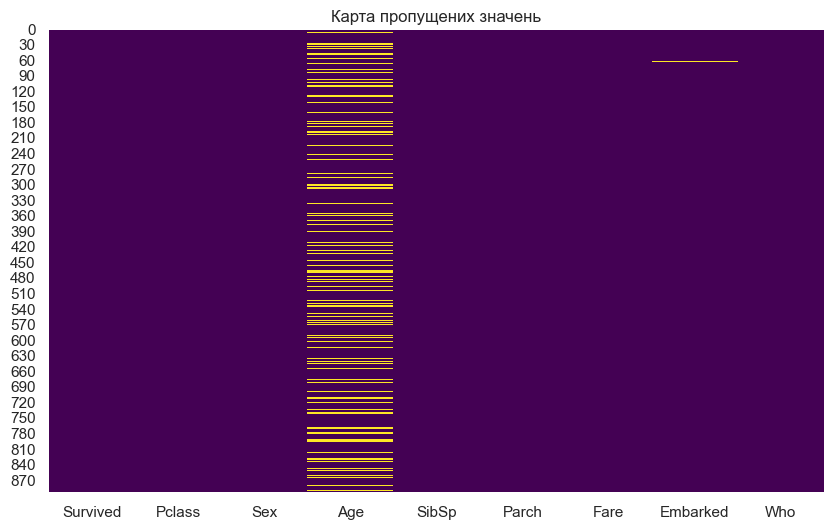

In [142]:
# Перевірка кількості пропущених значень
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Візуалізація пропусків
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Карта пропущених значень')
plt.show()

In [143]:
# 1. Обробка Age: Заповнення середнім (Mean Imputation)
mean_age = df['Age'].mean()
df['Age'].fillna(mean_age, inplace=True)
print(f"Пропуски в Age заповнено середнім значенням: {mean_age:.2f}")

# 2. Обробка Embarked: Заповнення модою (Mode Imputation)
mode_embarked = df['Embarked'].mode()
df['Embarked'].fillna(mode_embarked[0], inplace=True)

print(f"Пропуски в Embarked заповнено модою: {mode_embarked}")

Пропуски в Age заповнено середнім значенням: 29.70
Пропуски в Embarked заповнено модою: 0    S
Name: Embarked, dtype: object


In [144]:
# Створення нової ознаки FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch']

# One-Hot Encoding для Sex та Embarked
df_encoded = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=False)


# Видаляємо допоміжні колонки
if 'Who' in df_encoded.columns:
    df_encoded.drop('Who', axis=1, inplace=True)

# Перегляд підготовленого датасету
print("Підготовлені дані:")
display(df_encoded.head())


Підготовлені дані:


,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,1,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,0,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,1,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,0,False,True,False,False,True


In [145]:
# Визначення матриці ознак (X) та цільового вектора (y)
X = df_encoded.drop('Survived', axis=1)
y = df_encoded['Survived']

# Розділення на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Масштабування даних (критично для Логістичної Регресії)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Розмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")


Розмір тренувальної вибірки: (712, 11)
Розмір тестової вибірки: (179, 11)


In [146]:
# Ініціалізація моделей
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=5), # Обмежимо глибину для уникнення перенавчання
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100)
}

# Словник для збереження результатів
results = {}

def train_and_evaluate(model, X_train, X_test, y_train, y_test, scale=False):
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled, X_test_scaled = X_train, X_test
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    return y_pred, y_prob

# Цикл навчання та оцінки
for name, model in models.items():
    # Використовуємо масштабовані дані для Логістичної регресії, звичайні для дерев
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    # Розрахунок метрик
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC AUC": roc_auc,
        "Model Object": model,
        "Predictions": y_pred,
        "Probabilities": y_prob
    }
    
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")
    # Крос-валідація
from sklearn.model_selection import cross_val_score

cv_scores_lr = cross_val_score(LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
                               X_train_scaled, y_train, cv=5, scoring='accuracy')
print("CV Accuracy (Logistic Regression):", cv_scores_lr.mean())

cv_scores_dt = cross_val_score(DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced'),
                               X_train, y_train, cv=5, scoring='accuracy')
print("CV Accuracy (Decision Tree):", cv_scores_dt.mean())

y_pred, y_prob = train_and_evaluate(model, X_train, X_test, y_train, y_test, scale=(name=="Logistic Regression"))



--- Logistic Regression ---
Accuracy: 0.8045
F1 Score: 0.7244
ROC AUC: 0.8437

--- Decision Tree ---
Accuracy: 0.7654
F1 Score: 0.6557
ROC AUC: 0.8080

--- Random Forest ---
Accuracy: 0.8101
F1 Score: 0.7424
ROC AUC: 0.8336

CV Accuracy (Logistic Regression): 0.7837486457204766
CV Accuracy (Decision Tree): 0.7921993499458286


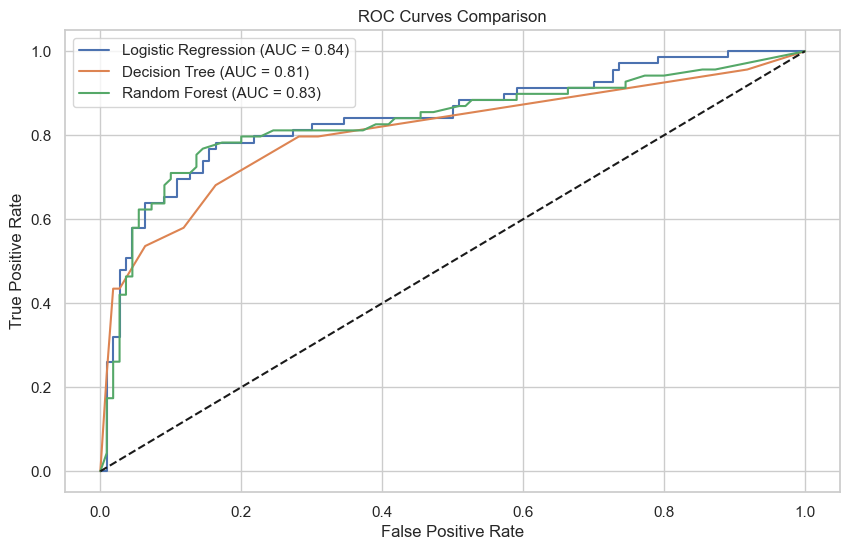

In [147]:
# Побудова ROC-кривих
plt.figure(figsize=(10, 6))

for name, metrics in results.items():
    fpr, tpr, _ = roc_curve(y_test, metrics["Probabilities"])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["ROC AUC"]:.2f})')

# Базова лінія
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()


Найкращі параметри: {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 300}
Найкраща точність (CV): 0.8217078695951935
Test Accuracy (Optimized RF): 0.8212


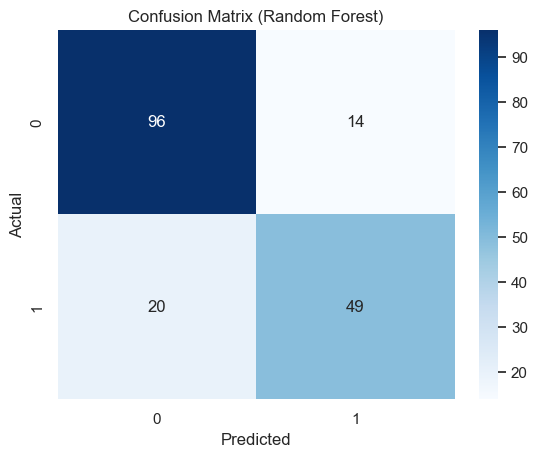

In [148]:
# Параметри для перебору
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 3, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Найкращі параметри:", grid_search.best_params_)
print("Найкраща точність (CV):", grid_search.best_score_)

# Оновлений оптимізований прогноз
best_rf = grid_search.best_estimator_
y_pred_opt = best_rf.predict(X_test)
print(f"Test Accuracy (Optimized RF): {accuracy_score(y_test, y_pred_opt):.4f}")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix ({name})")
plt.show()


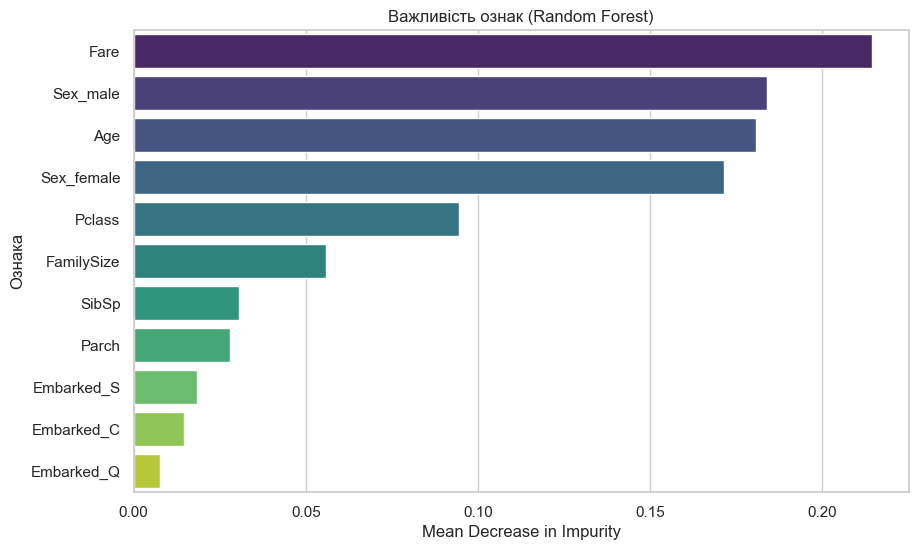

In [149]:
# Отримання важливості ознак з оптимізованої моделі
importances = best_rf.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Візуалізація
plt.figure(figsize=(10, 6))
sns.barplot(x=forest_importances.values, y=forest_importances.index, palette="viridis")
plt.title("Важливість ознак (Random Forest)")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Ознака")
plt.show()